**Se realizan imports y se establece una conexion con un drive de google + path a al dataset de rossman**

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from google.colab import drive
drive.mount('/content/gdrive')
PATH = '/content/gdrive/MyDrive/TEMP/dataset/rossmann/'

Mounted at /content/gdrive


https://www.youtube.com/watch?v=1-NYPQw5THU&feature=youtu.be

In [2]:
import pandas as pd
import numpy as np
import datetime
!pip install pandas_summary
from pandas_summary import DataFrameSummary
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model

**Se cargan los datos normalizados por notebooks 1-4 provistas por ITBA** 

In [3]:
df = pd.read_feather(PATH+'train_normalized_data.fth')
df_test = pd.read_feather(PATH+'test_normalized_data.fth')

# **Se remueven Outliers**


In [4]:
df['Date']
df['DateInt'] = df['Date'].astype(np.int64)


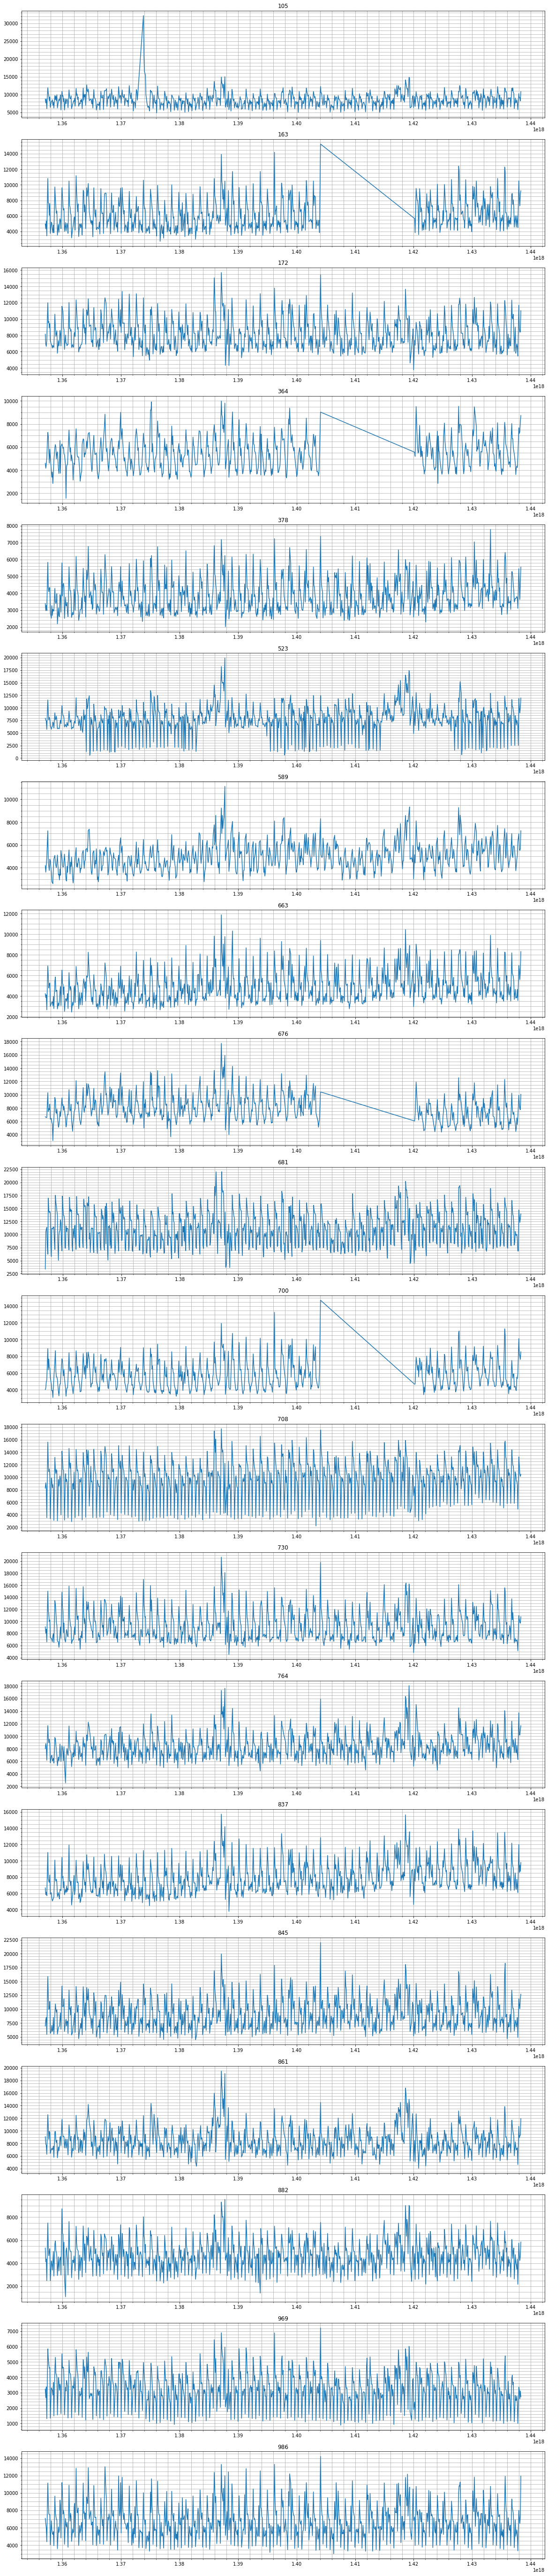

In [5]:
import matplotlib.pyplot as plt
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

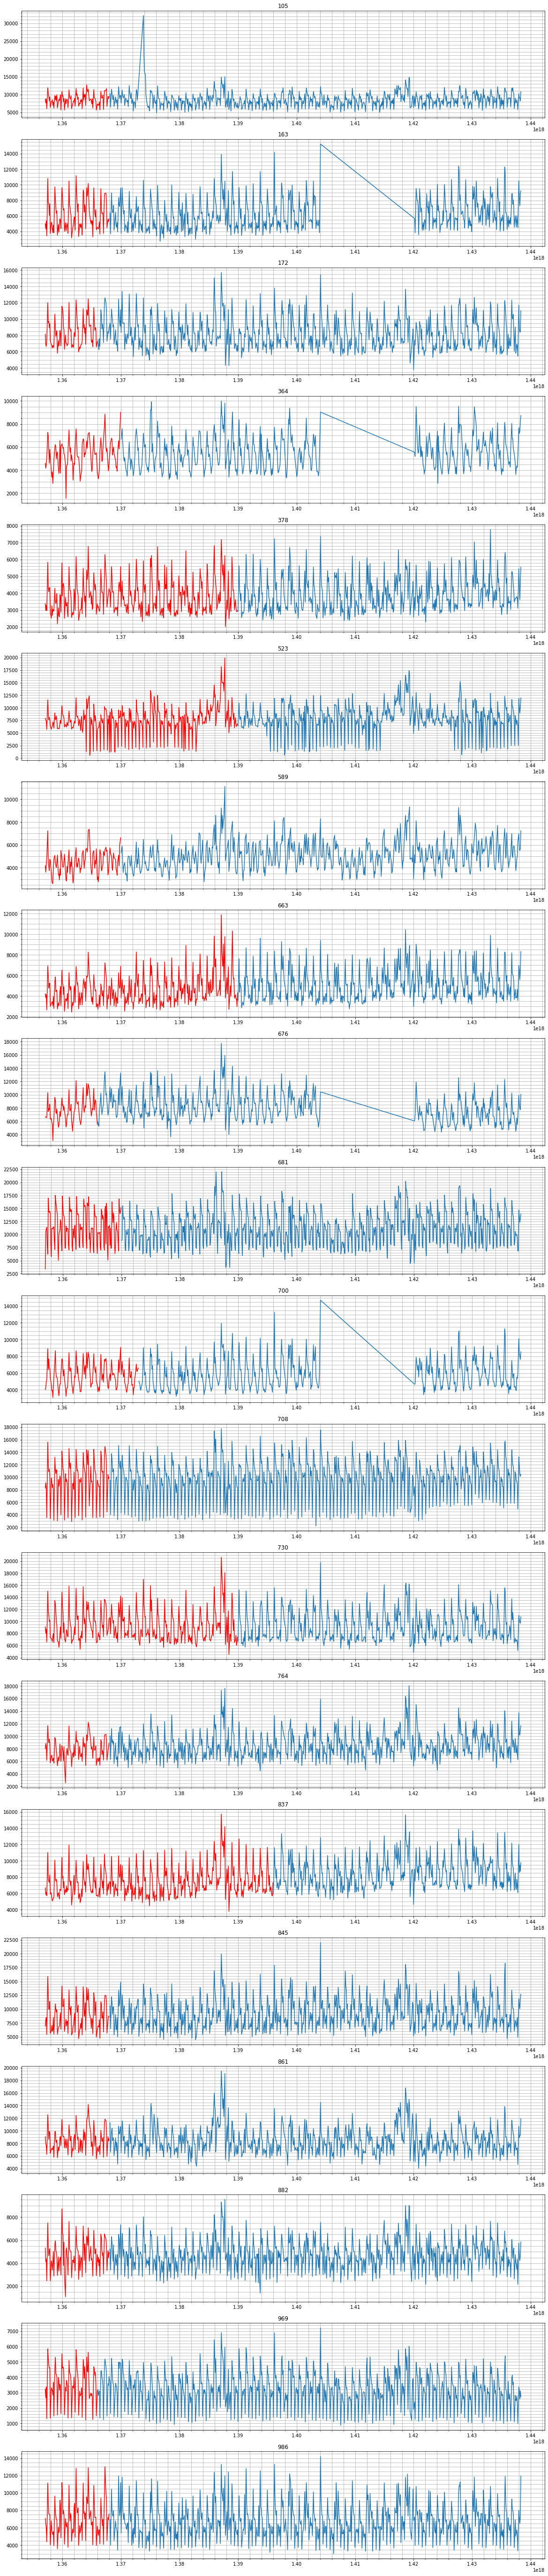

In [6]:
df['Delete']=False
df['Outlier'] = False
store_dates_to_remove =  {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

for key,value in store_dates_to_remove.items():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True


list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]
    y1 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]['Sales']
    
    X2 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]
    y2 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, 'r-')
    plt.plot(X2['DateInt'], y2, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

# Comprobacion (fer)

In [7]:
print("df antes ",df.shape)

'''
### Remove outliers
def mad_based_outlier(points, thresh=3):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh


for i in df['Store'].unique():
    df.loc[(df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = mad_based_outlier(df.loc[(df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)
'''

df = df.loc[df['Delete'] != True]
df = df.loc[df['Outlier'] == False]
print("df despues",df.shape)

                                                    


df antes  (844338, 85)
df despues (837030, 85)


# Fin comprobacion

In [8]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw','Open']

#embeddings_model.hdf5'
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day','StateHoliday','State','StoreType','Assortment']

#cat_vars = ['Store', 'DayOfWeek','StoreType','Year', 'Month', 'Day', 'State']
len(cat_vars)


9

In [9]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [10]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
# contin_vars = []

#embeddings_model.hdf5'
contin_vars = ['CompetitionDistance','Promo','Max_TemperatureC','BeforeStateHoliday_bool']
len(contin_vars)

4

In [11]:
y_out_columns = ['Sales']

In [12]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9639343870590062


In [13]:
X_train = df_train[cat_vars + contin_vars]
X_val = df_val[cat_vars + contin_vars]
X_test = df_test[cat_vars + contin_vars]

In [14]:
X_train.shape, X_val.shape

((806842, 13), (30188, 13))

In [15]:
log_output = True
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std

## Categorical columns transformation

In [16]:
# categoricals_processing = 'no_categoricals'
#categoricals_processing = 'use_onehotencoding'
categoricals_processing = 'use_embeddings'


# Agregado (Fer) Embedings


**para no tener que importar desde la notebook 5 el modelo de embedings lo agrego directamente en esta notebook y si cambio las categorias de entrada, direcatamente lo cambio todo en esta notebook**

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [18]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [19]:
cat_var_dict = {'Store': 10, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [20]:
from keras import optimizers
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)


#Modelo prueba
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(1000,kernel_initializer="uniform", activation='relu')(merged)
x = Dense(500, kernel_initializer="uniform",activation='relu')(x)
output = Dense(10, activation='linear')(x)
embeddings_model = Model(cat_var_inputs + cont_vars_inputs, output)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
embeddings_model.compile(optimizer=adam, metrics=['mse'], loss='mse')
embeddings_model.fit(np.hsplit(X_train, X_train.shape[1]), y_train, validation_data=(np.hsplit(X_val, X_val.shape[1]), y_val),  epochs=5, batch_size=256)


'''
#Modelo que funciona comprobado
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
embeddings_model = Model(cat_var_inputs + cont_vars_inputs, merged)
embeddings_model.compile(optimizer=Adam(lr=0.001), metrics=['mse'], loss='mse')
embeddings_model.fit(np.hsplit(X_train, X_train.shape[1]), y_train, validation_data=(np.hsplit(X_val, X_val.shape[1]), y_val),  epochs=5, batch_size=256)
'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
3152/3152 [==============================] - 85s 26ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 3.7829e-04 - val_mse: 3.7829e-04
Epoch 2/5
3152/3152 [==============================] - 81s 26ms/step - loss: 1.7751e-04 - mse: 1.7751e-04 - val_loss: 3.8384e-04 - val_mse: 3.8384e-04
Epoch 3/5
3152/3152 [==============================] - 81s 26ms/step - loss: 1.4456e-04 - mse: 1.4456e-04 - val_loss: 2.9073e-04 - val_mse: 2.9073e-04
Epoch 4/5
3152/3152 [==============================] - 81s 26ms/step - loss: 1.2627e-04 - mse: 1.2627e-04 - val_loss: 2.7875e-04 - val_mse: 2.7875e-04
Epoch 5/5
3152/3152 [==============================] - 81s 26ms/step - loss: 1.1497e-04 - mse: 1.1497e-04 - val_loss: 2.3124e-04 - val_mse: 2.3124e-04


"\n#Modelo que funciona comprobado\nmerged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)\nembeddings_model = Model(cat_var_inputs + cont_vars_inputs, merged)\nembeddings_model.compile(optimizer=Adam(lr=0.001), metrics=['mse'], loss='mse')\nembeddings_model.fit(np.hsplit(X_train, X_train.shape[1]), y_train, validation_data=(np.hsplit(X_val, X_val.shape[1]), y_val),  epochs=5, batch_size=256)\n"

# Fin agregado Embedings (fer)

In [21]:
X_train.shape

(806842, 13)

In [22]:
if categoricals_processing == 'use_embeddings':
    #embeddings_model = load_model('/content/gdrive/MyDrive/TEMP/dataset/rossmann/embeddings_model.hdf5')
    X_train = embeddings_model.predict(np.hsplit(X_train, X_train.shape[1]), verbose=1)
    X_val = embeddings_model.predict(np.hsplit(X_val, X_val.shape[1]), verbose=1)
    X_test = embeddings_model.predict(np.hsplit(X_test, X_test.shape[1]), verbose=1)

1284/1284 [==============================] - 6s 4ms/step


In [23]:
if categoricals_processing == 'use_onehotencoding':
    # Use One Hot Encoding
    categorical_feature_mask = [col in cat_vars for col in X_train.columns]
    ohe = OneHotEncoder(categorical_features = categorical_feature_mask)
    ohe.fit(X_train)
    X_train = ohe.transform(X_train)
    X_val = ohe.transform(X_val)
    X_test = ohe.transform(X_test)

In [24]:
X_train.shape

(806842, 10)

In [25]:
X_val.shape

(30188, 10)

In [26]:
X_test.shape

(41088, 10)

## XGBoost

In [27]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [28]:
n_estimators=4000
learning_rate=0.125
model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                     objective='reg:squarederror', n_jobs=12, max_depth=12, gamma=0.005)
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005,
             importance_type='gain', learning_rate=0.125, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=4000,
             n_jobs=12, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [29]:
fit_params={"early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_val, y_val.reshape(-1))],
            'verbose': 1,
           }

    

In [30]:
model.fit(X_train, y_train.reshape(-1), **fit_params)

[0]	validation_0-rmse:0.285754
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.249104
[2]	validation_0-rmse:0.217046
[3]	validation_0-rmse:0.189009
[4]	validation_0-rmse:0.164497
[5]	validation_0-rmse:0.143064
[6]	validation_0-rmse:0.124339
[7]	validation_0-rmse:0.107981
[8]	validation_0-rmse:0.093699
[9]	validation_0-rmse:0.081243
[10]	validation_0-rmse:0.070391
[11]	validation_0-rmse:0.060951
[12]	validation_0-rmse:0.052747
[13]	validation_0-rmse:0.045643
[14]	validation_0-rmse:0.039516
[15]	validation_0-rmse:0.034254
[16]	validation_0-rmse:0.029771
[17]	validation_0-rmse:0.025989
[18]	validation_0-rmse:0.022846
[19]	validation_0-rmse:0.020272
[20]	validation_0-rmse:0.018218
[21]	validation_0-rmse:0.01663
[22]	validation_0-rmse:0.01545
[23]	validation_0-rmse:0.014619
[24]	validation_0-rmse:0.014074
[25]	validation_0-rmse:0.013752
[26]	validation_0-rmse:0.013599
[27]	validation_0-rmse:0.013566
[28]	validation_0-rmse:0.013616
[29]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005,
             importance_type='gain', learning_rate=0.125, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=4000,
             n_jobs=12, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [31]:
score = model.score(X_val, y_val)

In [32]:
if log_output:
    y_pred_train = np.exp(model.predict(X_train)*max_log_y)
    y_pred = np.exp(model.predict(X_val)*max_log_y)
    y_pred_test = np.exp(model.predict(X_test)*max_log_y)
else:
    y_pred_train = model.predict(X_train)*y_std + y_mean
    y_pred = model.predict(X_val)*y_std + y_mean
    y_pred_test = model.predict(X_test)*y_std + y_mean

In [33]:
# Train
train_RMSE = np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train))

In [34]:
# Validación
val_RMSE = np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

In [35]:
print(score, train_RMSE, val_RMSE)

0.8710724385416097 0.1440515666361438 0.150447547369507


# Baseline

In [36]:
import pandas as pd
#sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')

In [37]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [38]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [39]:
df_test[['Store', 'Sales']].head(10)

Store        Sales
0      0  4759.096031
1      2  6942.568678
2      6  8817.050891
3      7  5539.358418
4      8  6562.337612
5      9  5568.420918
6     10  8030.977041
7     11  7589.598214
8     12  5034.747182
9     13  5508.567394

In [40]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

Store  Sales
543     702    0.0
676     878    0.0
840    1096    0.0
1399    702    0.0
1532    878    0.0

In [41]:
#sample_csv['Sales'] = df_test['Sales']

In [42]:
#sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [43]:
#sample_csv.head()

# Sumbit a la competición

In [44]:
sample_csv = pd.read_csv('/content/gdrive/MyDrive/TEMP/dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'/content/gdrive/MyDrive/TEMP/dataset/rossmann/submision_{log_output}-{n_estimators}-{learning_rate}.csv', index=False)

In [45]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'State',
 'StoreType',
 'Assortment']